In [10]:
import warnings

import dandelion as ddl
import pandas as pd
import scanpy as sc


from numba.core.errors import (
    NumbaDeprecationWarning,
)  # silence numba deprecation warning
from pathlib import Path
from tqdm import tqdm

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)
sc.settings.verbosity = 0

sc.logging.print_header()
ddl.logging.print_header()

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.4 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 pynndescent==0.5.10
dandelion==0.3.4.dev5 pandas==2.1.0 numpy==1.24.4 matplotlib==3.7.1 networkx==3.1 scipy==1.11.2


In [11]:
DATA_PATH = Path("..") / "data"
LOCAL_PATH = DATA_PATH / "local"

for p in [DATA_PATH, LOCAL_PATH]:
    p.mkdir(exist_ok=True)

In [12]:
meta = pd.read_csv(DATA_PATH / "vdj_b" / "metadata.csv", index_col=0)
meta

prefix individual          Treatment Timepoint
sample_id                                                              
G000421_batch1_1        BC1-CpG        BC1                CpG       72h
G000421_batch1_2        BC2-CpG        BC2                CpG       72h
G000421_batch1_3   BC1-CD40-72h        BC1  anti-CD40_IL4_IL5       72h
G000421_batch1_4   BC2-CD40-72h        BC2  anti-CD40_IL4_IL5       72h
G000421_batch2_1  BC1-CD40-120h        BC1  anti-CD40_IL4_IL5      120h
G000421_batch2_2  BC2-CD40-120h        BC2  anti-CD40_IL4_IL5      120h

In [13]:
adatas = []
for sample in tqdm(meta.index):
    prefix = meta.loc[sample, "prefix"]
    adata = sc.read_10x_mtx(
        DATA_PATH / "filtered" / f"{sample}" / "sample_filtered_feature_bc_matrix"
    )
    adata.obs_names = [f"{prefix}_{i}" for i in adata.obs_names]
    for col in meta:
        if col == "prefix":
            adata.obs["sample_id_actual"] = meta.loc[sample, col]
        elif col == "individual":
            adata.obs["culture_id"] = meta.loc[sample, col]
        else:
            adata.obs[col] = meta.loc[sample, col]
    # run basic preprocessing
    ddl.pp.external.recipe_scanpy_qc(
        adata, mito_startswith="mt-", max_genes=6000, min_genes=200, mito_cutoff=None
    )  # https://sc-dandelion.readthedocs.io/en/latest/modules/dandelion.preprocessing.external.recipe_scanpy_qc.html
    adatas.append(adata)

100%|██████████| 6/6 [04:06<00:00, 41.07s/it]


In [14]:
# concatenate
adata = adatas[0].concatenate(adatas[1:], index_unique=None)
adata.layers["counts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 53648 × 32285
    obs: 'sample_id_actual', 'culture_id', 'Treatment', 'Timepoint', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'gene_ids', 'feature_types'
    layers: 'counts'

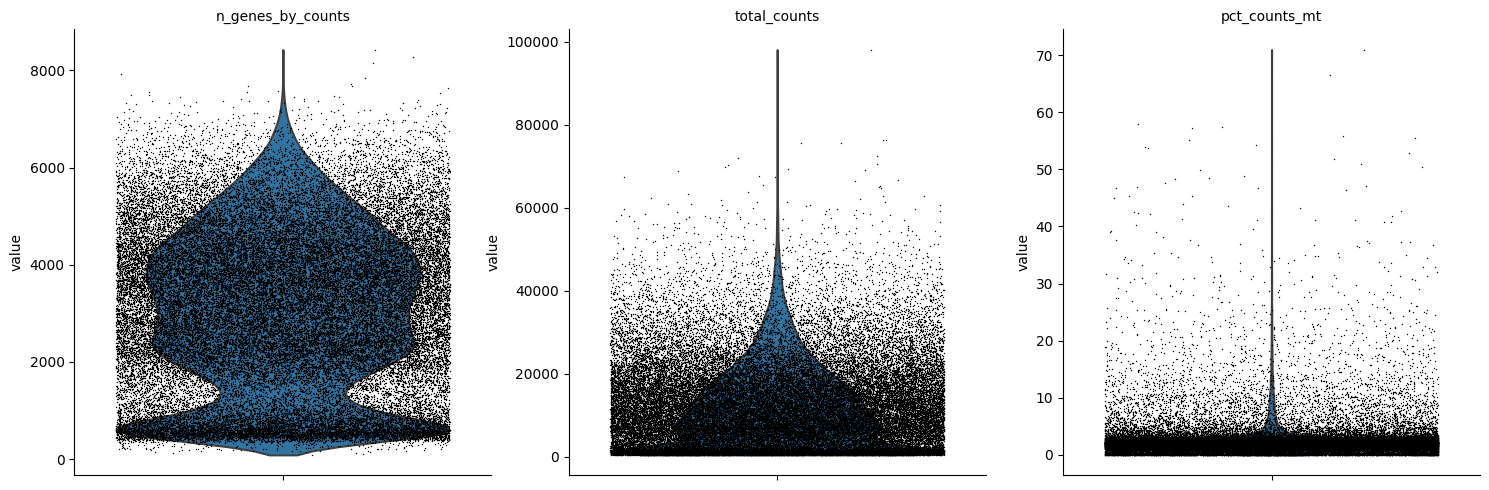

In [15]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

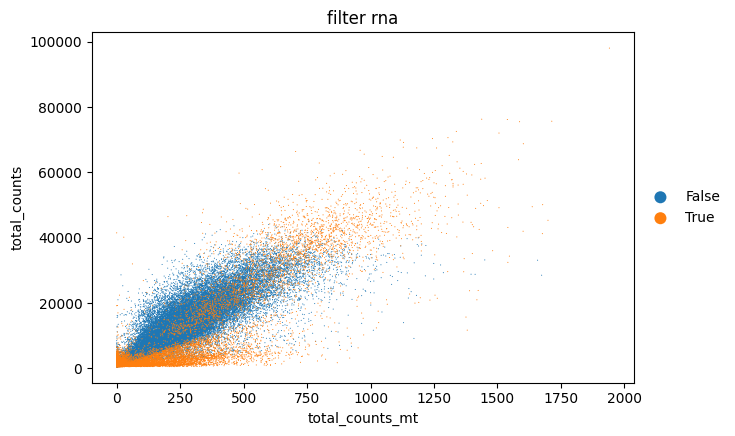

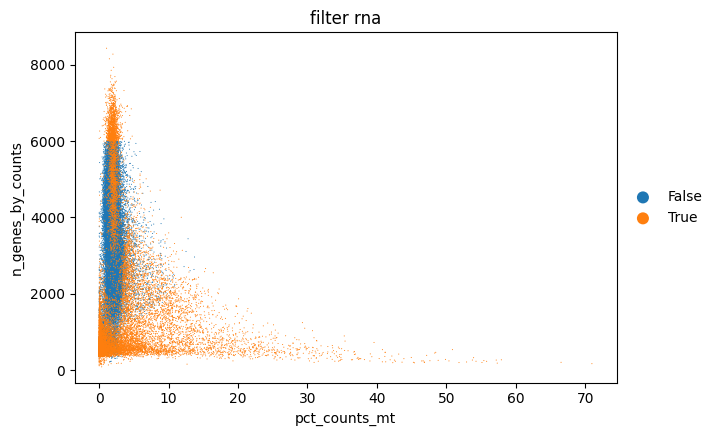

In [16]:
sc.pl.scatter(adata, x="total_counts_mt", y="total_counts", color="filter_rna")
sc.pl.scatter(adata, x="pct_counts_mt", y="n_genes_by_counts", color="filter_rna")

In [17]:
# save before continuing
adata.write_h5ad(LOCAL_PATH / "adata_raw_counts.h5ad", compression="gzip")

In [18]:
# normally we will filter the low quality ones first, but for the sake of the hackathon, # for the purpose of the hackathon, we will use the unfiltered data to proceed.
# if people want to do some filtering, they can just restart
sc.pp.normalize_total(adata, target_sum=1e4)

In [19]:
sc.pp.log1p(adata)

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

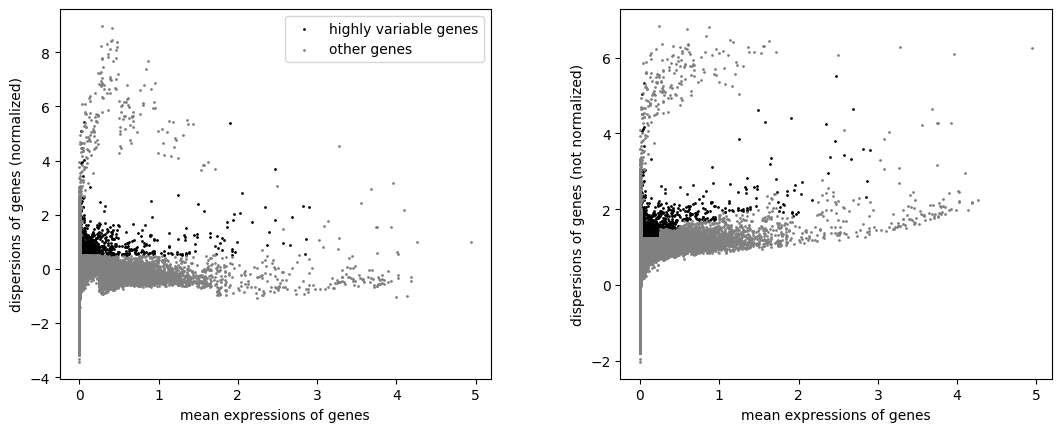

In [21]:
import re

for i in adata.var.index:
    if re.search("Ig[hkl][vdjc]", i):
        adata.var.loc[i, "highly_variable"] = False
sc.pl.highly_variable_genes(adata)

In [22]:
adata.raw = adata

In [23]:
# save before continuing
adata.write_h5ad(LOCAL_PATH / "adata_norm_counts.h5ad", compression="gzip")

In [24]:
# filter to hvg
# adata = sc.read_h5ad(DATA_PATH / "adata_norm_counts.h5ad")
adata = adata[:, adata.var.highly_variable].copy()

In [25]:
adata

AnnData object with n_obs × n_vars = 53648 × 1871
    obs: 'sample_id_actual', 'culture_id', 'Treatment', 'Timepoint', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'filter_rna_colors', 'log1p', 'hvg'
    layers: 'counts'

In [26]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

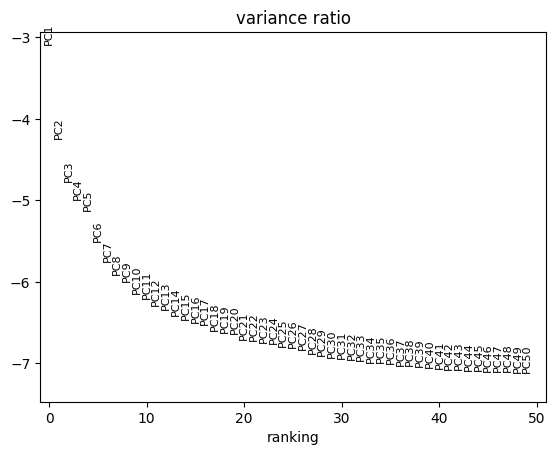

In [27]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [28]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserW

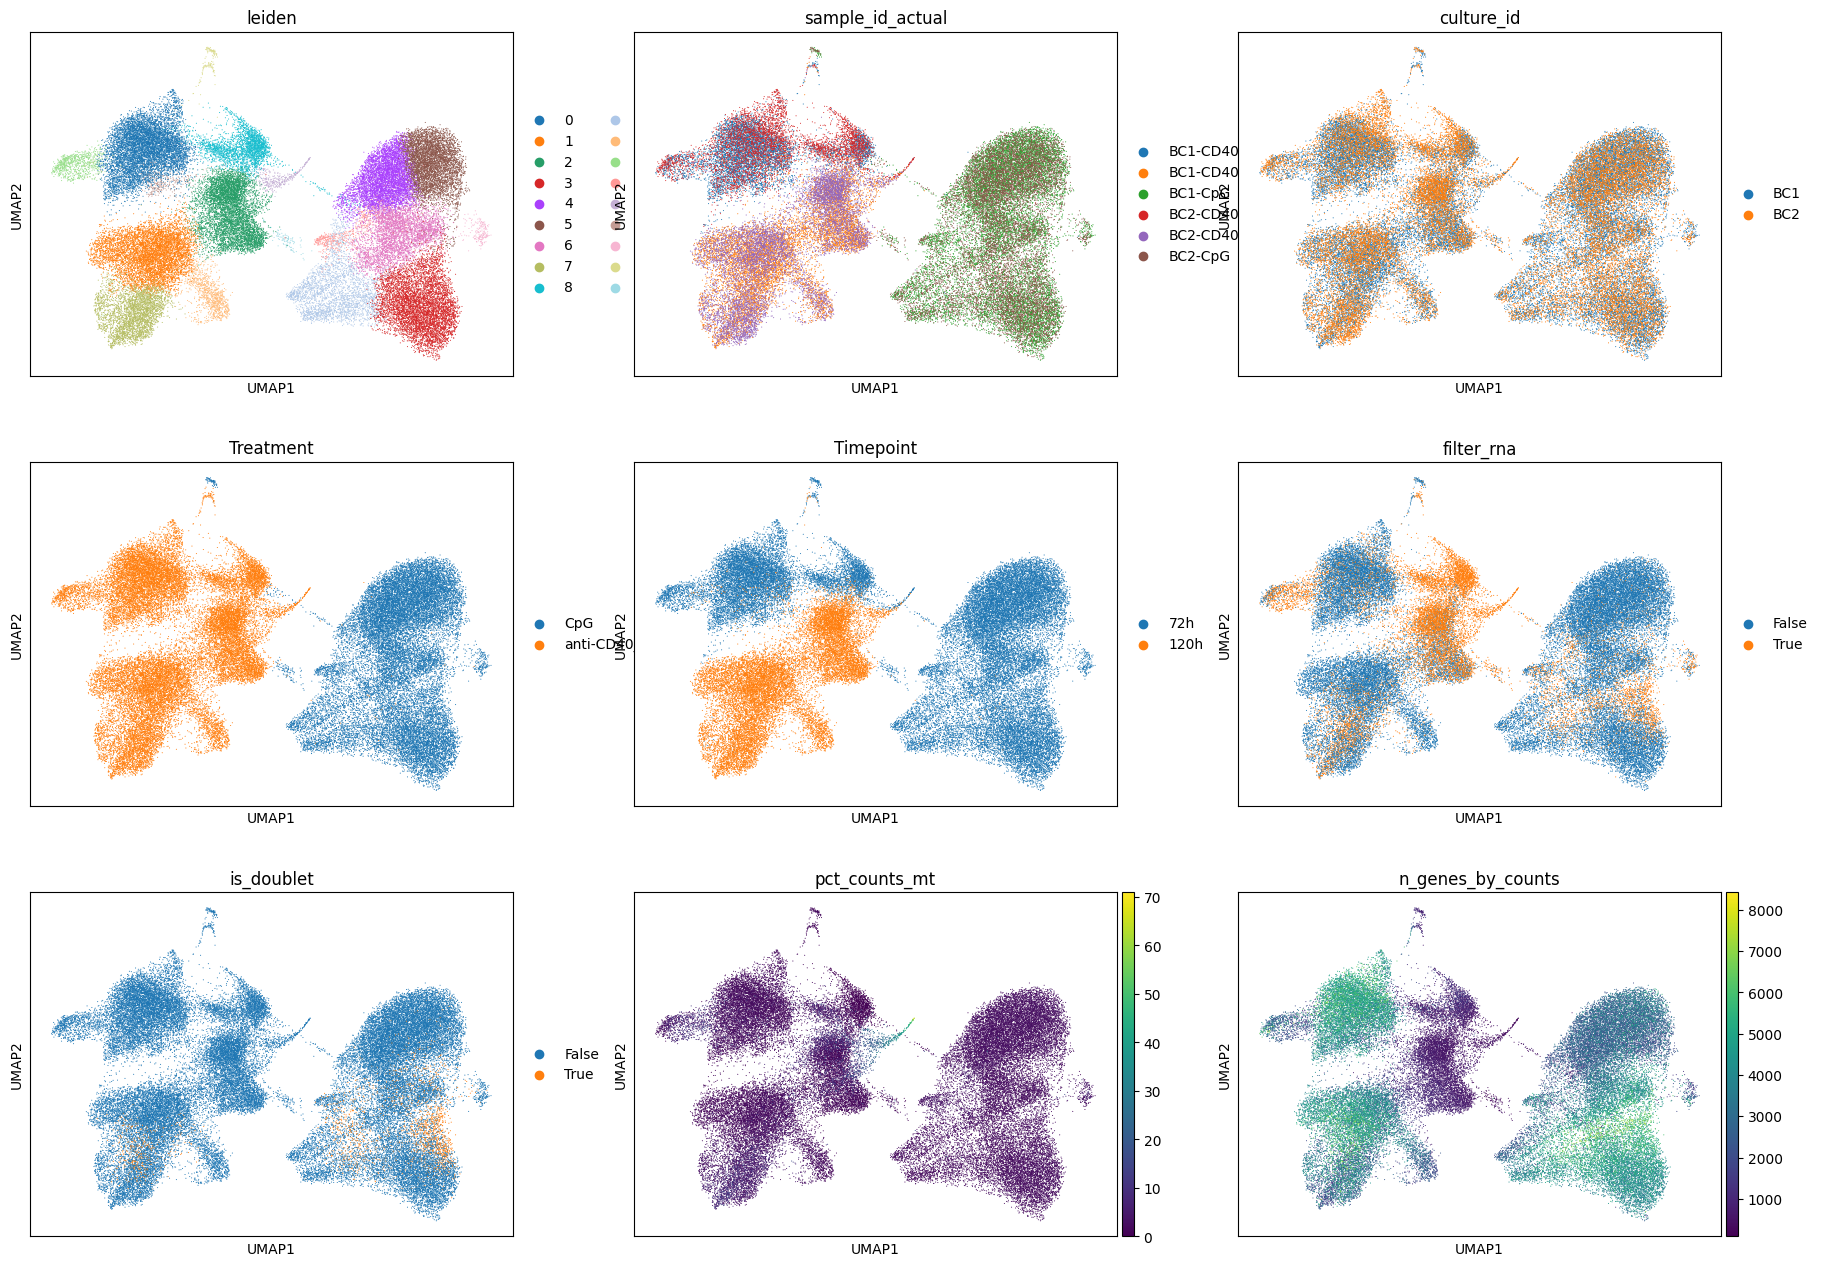

In [29]:
sc.pl.umap(
    adata,
    color=[
        "leiden",
        "sample_id_actual",
        "culture_id",
        "Treatment",
        "Timepoint",
        "filter_rna",
        "is_doublet",
        "pct_counts_mt",
        "n_genes_by_counts",
    ],
    ncols=3,
)

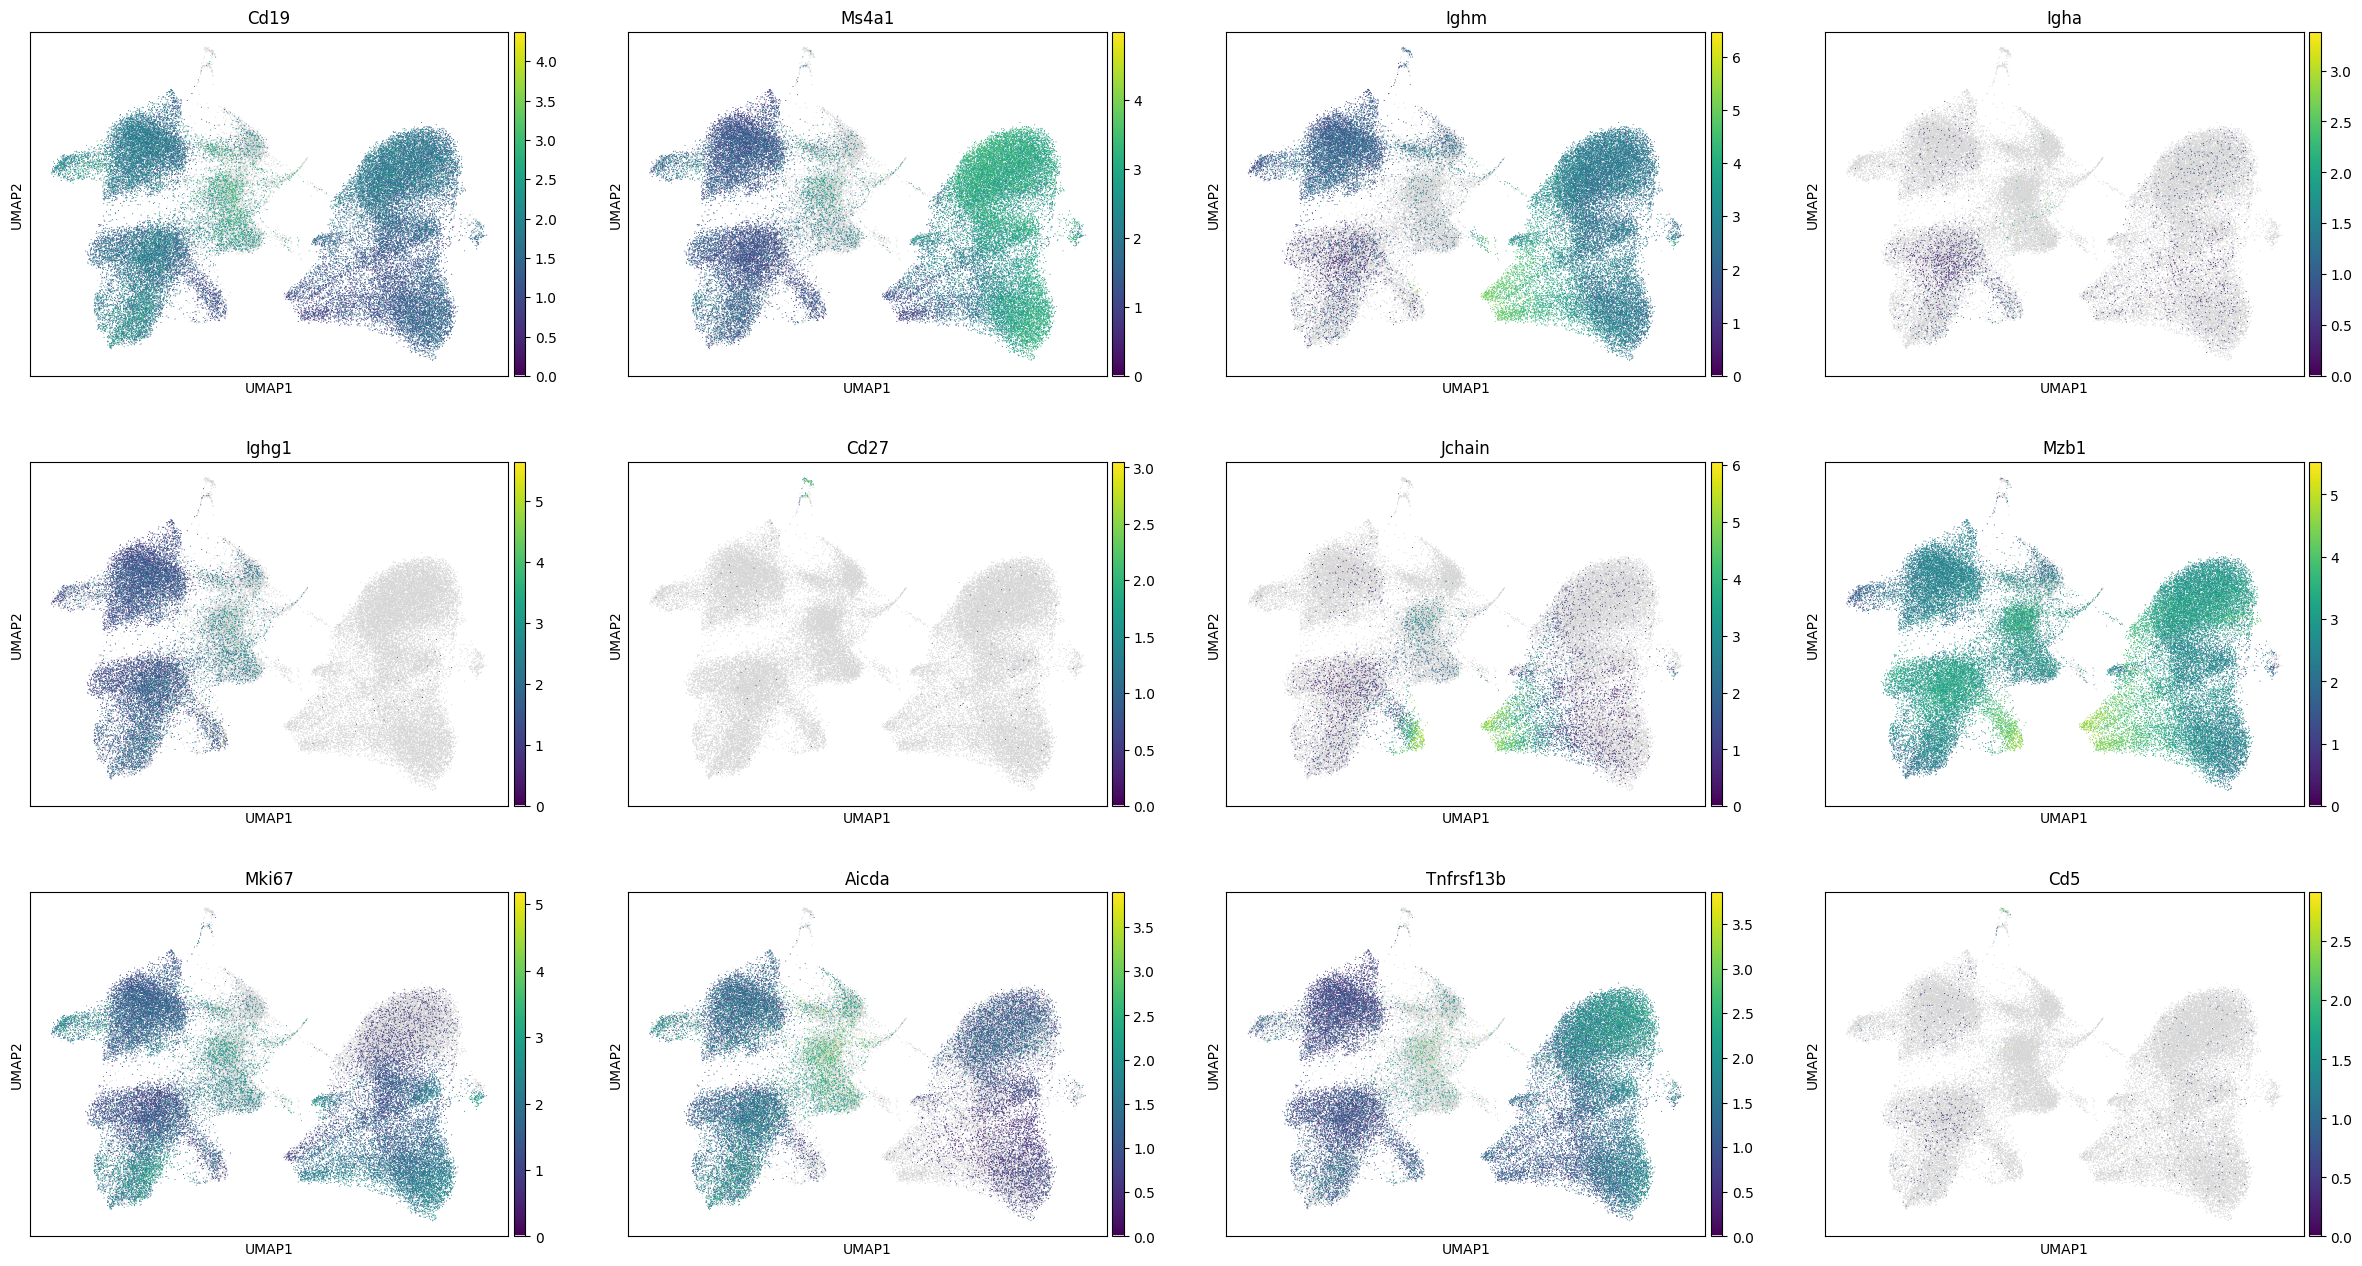

In [30]:
import tools

sc.pl.umap(
    adata,
    color=[
        "Cd19",
        "Ms4a1",
        "Ighm",
        "Igha",
        "Ighg1",
        "Cd27",
        "Jchain",
        "Mzb1",
        "Mki67",
        "Aicda",
        "Tnfrsf13b",
        "Cd5",
    ],
    color_map=tools.cmp(),
)

In [31]:
# save before continuing
if "log1p" in adata.uns:
    adata.uns.pop("log1p")
adata.write_h5ad(LOCAL_PATH / "adata_umap.h5ad", compression="gzip")

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


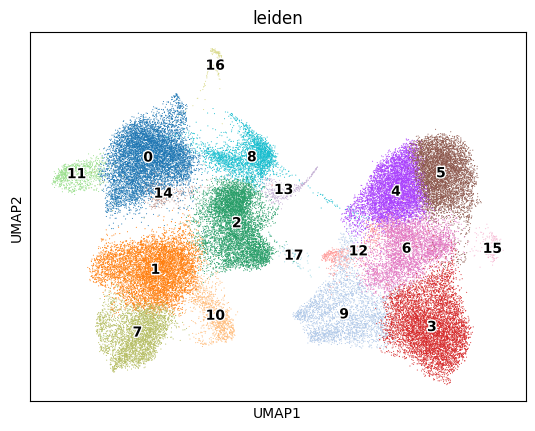

In [32]:
# let's give each leiden cluster a name
sc.pl.umap(adata, color=["leiden"], legend_loc="on data", legend_fontoutline=2)

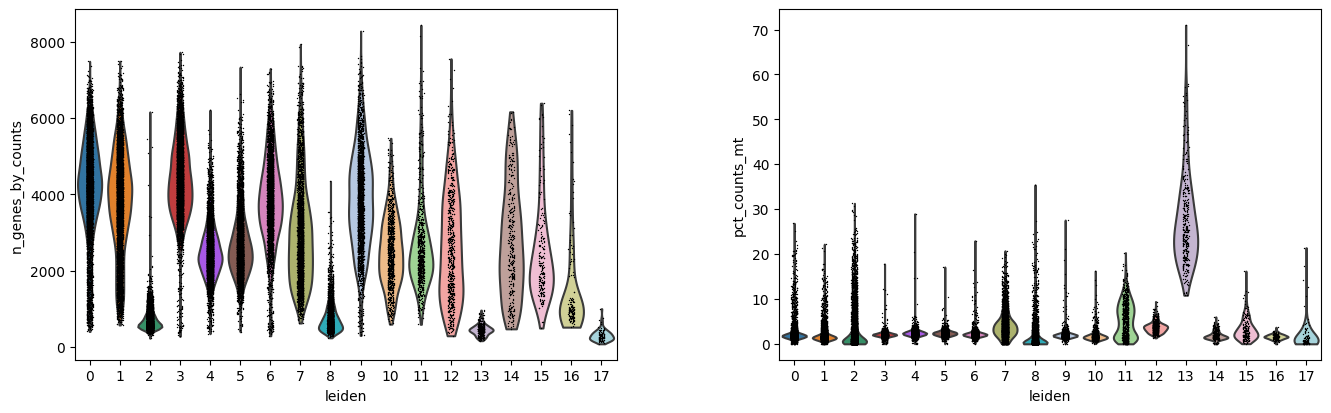

In [33]:
sc.pl.violin(adata, ["n_genes_by_counts", "pct_counts_mt"], groupby="leiden")

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


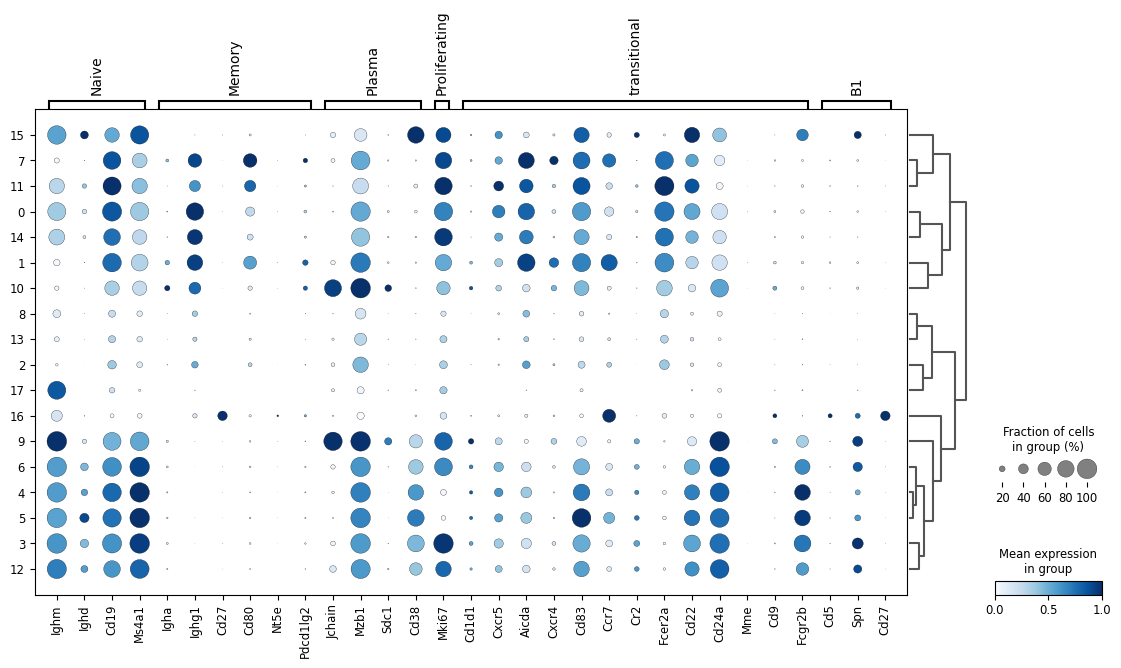

In [34]:
sc.pl.dotplot(
    adata,
    {
        "Naive": [
            "Ighm",
            "Ighd",
            "Cd19",
            "Ms4a1",
        ],
        "Memory": [
            "Igha",
            "Ighg1",
            "Cd27",
            "Cd80",
            "Nt5e",
            "Pdcd1lg2",
        ],
        "Plasma": [
            "Jchain",
            "Mzb1",
            "Sdc1",
            "Cd38",
        ],
        "Proliferating": [
            "Mki67",
        ],
        "transitional": [
            "Cd1d1",
            "Cxcr5",
            "Aicda",
            "Cxcr4",
            "Cd83",
            "Ccr7",
            "Cr2",  # CD21
            "Fcer2a",  # CD23
            "Cd22",
            "Cd24a",
            "Mme",
            "Cd9",
            "Fcgr2b",
        ],
        "B1": ["Cd5", "Spn", "Cd27"],
    },
    groupby="leiden",
    standard_scale="var",
    color_map="Blues",
    dendrogram=True,
)

In [ ]:
# Transitional 1 B = CD21lo, CD22hi, CD23-, CD24hi
# Transitional 2 B = CD21hi, CD22hi, CD23+, CD24hi
# Follicular B = CD21hi, CD22hi, CD23hi, CD24lo
# MZ B = CD21-, CD23-

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


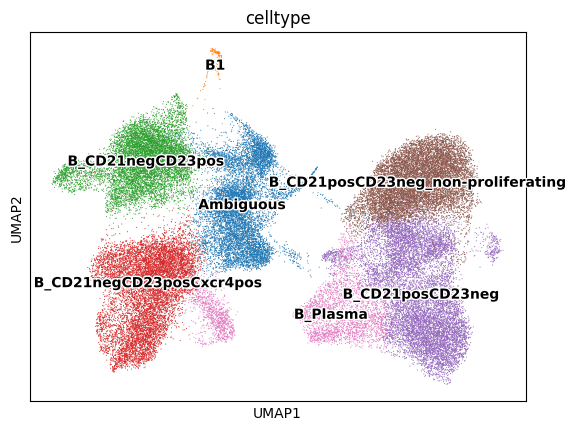

In [36]:
cell_dict1 = {
    "0": "B_CD21negCD23pos",
    "1": "B_CD21negCD23posCxcr4pos",
    "2": "Ambiguous",
    "3": "B_CD21posCD23neg",
    "4": "B_CD21posCD23neg_non-proliferating",
    "5": "B_CD21posCD23neg_non-proliferating",
    "6": "B_CD21posCD23neg",
    "7": "B_CD21negCD23posCxcr4pos",
    "8": "Ambiguous",
    "9": "B_Plasma",
    "10": "B_Plasma",
    "11": "B_CD21negCD23pos",
    "12": "B_CD21posCD23neg",
    "13": "Ambiguous",
    "14": "B_CD21negCD23pos",
    "15": "B_CD21posCD23neg",
    "16": "B1",
    "17": "Ambiguous",
}
adata.obs["celltype"] = [cell_dict1[i] for i in adata.obs.leiden]
sc.pl.umap(adata, color="celltype", legend_loc="on data", legend_fontoutline=2)

In [37]:
adata

AnnData object with n_obs × n_vars = 53648 × 1871
    obs: 'sample_id_actual', 'culture_id', 'Treatment', 'Timepoint', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'filter_rna_colors', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'sample_id_actual_colors', 'culture_id_colors', 'Treatment_colors', 'Timepoint_colors', 'is_doublet_colors', 'dendrogram_leiden', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [38]:
# save before continuing
if "log1p" in adata.uns:
    adata.uns.pop("log1p")
adata.write_h5ad(LOCAL_PATH / "adata_umap.h5ad", compression="gzip")

In [39]:
# adata = sc.read_h5ad(LOCAL_PATH / "adata_umap.h5ad")
# adata

In [40]:
import dandelion as ddl

bcrs = []
for sample in meta.index:
    bcr = ddl.Dandelion(
        DATA_PATH / "vdj_b" / f"{sample}" / "dandelion" / "all_contig_dandelion.tsv"
    )
    bcr = bcr[bcr.metadata_names.isin(adata.obs_names)].copy()
    bcrs.append(bcr)
bcr = ddl.concat(bcrs)
bcr

/Users/uqztuong/Library/CloudStorage/OneDrive-TheUniversityofQueensland/Documents/GitHub/dandelion/dandelion/utilities/_utilities.py:582: DtypeWarning: Columns (116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/uqztuong/Library/CloudStorage/OneDrive-TheUniversityofQueensland/Documents/GitHub/dandelion/dandelion/utilities/_utilities.py:582: DtypeWarning: Columns (116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/uqztuong/Library/CloudStorage/OneDrive-TheUniversityofQueensland/Documents/GitHub/dandelion/dandelion/utilities/_utilities.py:582: DtypeWarning: Columns (116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/uqztuong/Library/CloudStorage/OneDrive-TheUniversityofQueensland/Documents/GitHub/dandelion/dandelion/utilities/_utilities.py:582: DtypeWarning: Columns (116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/u

Dandelion class object with n_obs = 46737 and n_contigs = 125490
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'duplicate_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_

In [41]:
bcrx, adatax = ddl.pp.filter_contigs(bcr, adata)

Preparing data: 108750it [00:15, 7169.18it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 46446/46446 [01:54<00:00, 406.72it/s]


In [42]:
# global clones
ddl.tl.find_clones(bcrx)

Finding clones based on B cell VDJ chains : 100%|██████████| 361/361 [00:00<00:00, 1460.12it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 29181/29181 [00:00<00:00, 477843.92it/s]


In [43]:
import os

bcrx.write_h5ddl(LOCAL_PATH / "bcr_all.h5ddl")
bcrx.write_airr(DATA_PATH / "vdj_b" / "bcr_all_airr.tsv")
os.system("gzip -f " + str(DATA_PATH / "vdj_b" / "bcr_all_airr.tsv"))

/Users/uqztuong/Library/CloudStorage/OneDrive-TheUniversityofQueensland/Documents/GitHub/dandelion/dandelion/utilities/_core.py:1112: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call',
       'j_call', 'sequence_alignment', 'germline_alignment', 'junction',
       'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon',
       'vj_in_frame', 'locus', 'c_call', 'fwr1', 'fwr2', 'fwr3', 'fwr4',
       'cdr1', 'cdr2', 'cdr3', 'cell_id', 'v_call_10x', 'd_call_10x',
       'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_call_igblastn',
       'j_call_blastn', 'j_sequence_alignment_blastn',
       'j_germline_alignment_blastn', 'd_call_igblastn', 'd_call_blastn',
       'd_sequence_alignment_blastn', 'd_germline_alignment_blastn',
       'd_source', 'v_call_genotyped', 'germline_alig

0

In [44]:
# split to BC1 and BC2
bc1_adatax = adatax[adatax.obs.culture_id == "BC1"].copy()
bc2_adatax = adatax[adatax.obs.culture_id == "BC2"].copy()

bc1_bcrx = bcrx[bcrx.metadata_names.isin(bc1_adatax.obs_names)].copy()
bc2_bcrx = bcrx[bcrx.metadata_names.isin(bc2_adatax.obs_names)].copy()

In [45]:
ddl.tl.find_clones(bc1_bcrx)
ddl.tl.find_clones(bc2_bcrx)

Finding clones based on B cell VDJ chains : 100%|██████████| 345/345 [00:00<00:00, 2772.16it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 16981/16981 [00:00<00:00, 505324.57it/s]
Finding clones based on B cell VDJ chains : 100%|██████████| 338/338 [00:00<00:00, 3346.97it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 12200/12200 [00:00<00:00, 566571.91it/s]


In [46]:
ddl.tl.clone_size(bcrx)
ddl.tl.clone_size(bcrx, max_size=3)
ddl.tl.clone_size(bcrx, max_size=10)
bcrx.update_plus(option="all")
ddl.tl.transfer(adatax, bcrx)

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
/Users/uqztuong/Library/CloudStorage/OneDrive-TheUniversityofQueensland/Documents/GitHub/dandelion/dandelion/tools/_tools.py:706: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/Users/uqztuong/Library/CloudStorage/OneDrive-TheUniversityofQueensland/Documents/GitHub/dandelion/dandelion/tools/_tools.py:706: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [47]:
ddl.tl.transfer(bc1_adatax, bc1_bcrx)
ddl.tl.transfer(bc2_adatax, bc2_bcrx)

In [48]:
bc1_bcrx.update_plus(option="all")
bc2_bcrx.update_plus(option="all")

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide


In [49]:
bc1_bcrx.write_h5ddl(LOCAL_PATH / "bcr_bc1.h5ddl")
bc1_bcrx.write_airr(DATA_PATH / "vdj_b" / "bcr_bc1_airr.tsv")
os.system("gzip -f " + str(DATA_PATH / "vdj_b" / "bcr_bc1_airr.tsv"))

bc2_bcrx.write_h5ddl(LOCAL_PATH / "bcr_bc2.h5ddl")
bc2_bcrx.write_airr(DATA_PATH / "vdj_b" / "bcr_bc2_airr.tsv")
os.system("gzip -f " + str(DATA_PATH / "vdj_b" / "bcr_bc2_airr.tsv"))

/Users/uqztuong/Library/CloudStorage/OneDrive-TheUniversityofQueensland/Documents/GitHub/dandelion/dandelion/utilities/_core.py:1112: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call',
       'j_call', 'sequence_alignment', 'germline_alignment', 'junction',
       'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon',
       'vj_in_frame', 'locus', 'c_call', 'fwr1', 'fwr2', 'fwr3', 'fwr4',
       'cdr1', 'cdr2', 'cdr3', 'cell_id', 'v_call_10x', 'd_call_10x',
       'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_call_igblastn',
       'j_call_blastn', 'j_sequence_alignment_blastn',
       'j_germline_alignment_blastn', 'd_call_igblastn', 'd_call_blastn',
       'd_sequence_alignment_blastn', 'd_germline_alignment_blastn',
       'd_source', 'v_call_genotyped', 'germline_alig

0

In [50]:
adatax.obs["clone_id_separate_bc"] = adatax.obs["clone_id"].astype(str)
adatax.obs["clone_id_by_size_separate_bc"] = adatax.obs["clone_id_by_size"].astype(str)
bc1_adatax.obs["clone_id"] = ["bc1_" + x for x in bc1_adatax.obs["clone_id"]]
bc2_adatax.obs["clone_id"] = ["bc2_" + x for x in bc2_adatax.obs["clone_id"]]
bc1_adatax.obs["clone_id_by_size"] = [
    "bc1_" + str(x) for x in bc1_adatax.obs["clone_id_by_size"]
]
bc2_adatax.obs["clone_id_by_size"] = [
    "bc2_" + str(x) for x in bc2_adatax.obs["clone_id_by_size"]
]

adatax.obs["clone_id_separate_bc"].update(bc1_adatax.obs["clone_id"])
adatax.obs["clone_id_separate_bc"].update(bc2_adatax.obs["clone_id"])

adatax.obs["clone_id_by_size_separate_bc"].update(bc1_adatax.obs["clone_id_by_size"])
adatax.obs["clone_id_by_size_separate_bc"].update(bc2_adatax.obs["clone_id_by_size"])

/var/folders/_r/j_8_fj3x28n2th3ch0ckn9c40000gt/T/ipykernel_52732/605099641.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/_r/j_8_fj3x28n2th3ch0ckn9c40000gt/T/ipykernel_52732/605099641.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


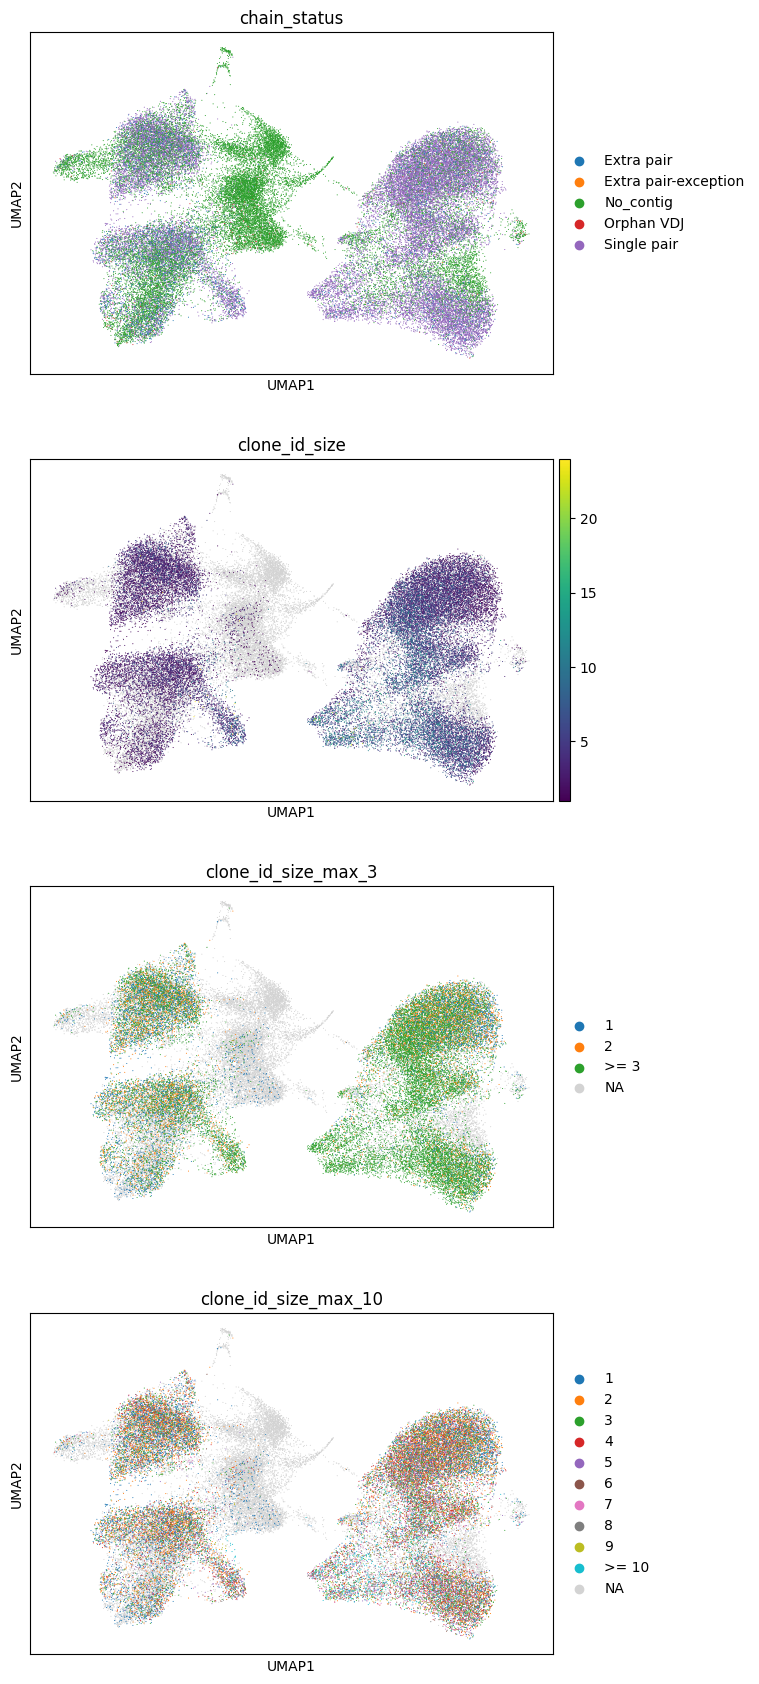

In [51]:
sc.pl.umap(
    adatax,
    color=[
        "chain_status",
        "clone_id_size",
        "clone_id_size_max_3",
        "clone_id_size_max_10",
    ],
    ncols=1,
)

In [52]:
adatax

AnnData object with n_obs × n_vars = 53648 × 1871
    obs: 'sample_id_actual', 'culture_id', 'Treatment', 'Timepoint', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch', 'leiden', 'celltype', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_

In [53]:
adatax.write_h5ad(LOCAL_PATH / "adata_umap_bcr.h5ad", compression="gzip")

In [54]:
# read in the other files too and transfer
for file in ["adata_norm_counts", "adata_raw_counts"]:
    tmp = sc.read_h5ad(LOCAL_PATH / f"{file}.h5ad")
    for x in adata.obsm:
        tmp.obsm[x] = adata.obsm[x].copy()
    for x in adata.obsp:
        tmp.obsp[x] = adata.obsp[x].copy()
    tmp.write_h5ad(LOCAL_PATH / f"{file}.h5ad", compression="gzip")

    for col in adatax.obs:
        if col not in tmp.obs:
            tmp.obs[col] = adatax.obs[col]
    tmp.write_h5ad(LOCAL_PATH / f"{file}_bcr.h5ad", compression="gzip")